<a href="https://colab.research.google.com/github/dipayandas97/Indoor-Navigation-System/blob/master/(3)_multi_layer_SNN_%26_GA_%26_Rate_Coded_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from neuron_models import LIF
from GA import GA
from SNN_Model import SNN_Model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Data preparation

In [0]:
class rate_encode:
    def __init__(self, time_window, input_range, output_range):
        self.time_window = time_window
        self.min_input = input_range[0]
        self.max_input = input_range[1]
        self.min_output = output_range[0]
        self.max_output = output_range[1]

    def encode(self, vector): #1D vector
        spike_train = []
        for v in vector:
            freq = (((v-self.min_input)/(self.max_input-self.min_input)) * (self.max_output-self.min_output)) + self.min_output 
            t = (1 / freq) * 1000 #ms                    
            spikes = np.zeros(self.time_window)
            k=0
            while k<self.time_window:
                spikes[k] = 1
                k += int(t)
            spike_train.append(spikes)
        spike_train = np.asarray(spike_train)
        return spike_train   

In [0]:
#functions to transform scaler data to spike time points and vice versa
#[a,b] : Min,Max value of temporal encoding
#[M:m] : Max,Min value that variable f can take

def scaler_to_temporal_value(f):
    #return (((b-a)/(M-m))*f) + (((a*M)-(b*m))/(M-m))
    return 33+(3*f) #since input range[0,22] so output range will be [0,66]. additional 33 settling time can be allotted in the beginning
    
def temporal_to_scaler_value(y):
    #return (y - (((a*M)-(b*m))/(M-m))) / ((b-a)/(M-m))
    return (y-33)/3

In [5]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl', 'rb')
X, Y = pickle.load(f)
f.close()

#Rate Encode X
encoder = rate_encode(100, (-110,-22), (10, 200))
signal_X = []
for x in X:
    signal_X.append(encoder.encode(x))
signal_X = np.asarray(signal_X)

#Time Encode Y
signal_Y = []
min_y, max_y = np.min(Y), np.max(Y)
for y in Y:
    t = scaler_to_temporal_value(f=y)
    spikes_y = np.zeros((2,100))
    spikes_y[0][t[0]], spikes_y[1][t[1]] = 1,1
    signal_Y.append(spikes_y)
signal_Y = np.asarray(signal_Y)

X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)



Train sizes:  (4080, 4, 100) (4080, 2, 100)
Test sizes:  (1020, 4, 100) (1020, 2, 100)


#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 5:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1] - true_timestamps[d]

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##mp_fitness()

In [0]:
#Multi-proecssing

def mp_fitness(synapse_vector, output): #fitness of one vectored synapse
    
    #Network instance for this sub-process
    model = SNN_Model(input_dim=4, neurons_per_layer=[6,2], threshold=0.05, Cm=2)  
    initial_synapse_list = model.synapse_list
    
    synapse_id = synapse_vector[-1] 
    synapse_vector = synapse_vector[:-1]
    synapse_matrices_list = ga.vector_to_matrix(vector = synapse_vector, dummy_matrices=initial_synapse_list)

    model.set_synapses(synapse_matrices_list)

    #Error on train_data
    temp_train_score = []      
    for i in range(X_train.shape[0]):     
        model_output = model.predict(X_train[i])[-1]    #Last array represents activations of output layer
        temp_train_score.append( error(y_train[i],model_output) )

    #Error on test data
    temp_test_score = []        
    for i in range(X_test.shape[0]):   
        model_output = model.predict(X_test[i])[-1]    #Last array represents activations of output layer      
        temp_test_score.append( error(y_test[i], model_output) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Parallel GA

Generation :  1 / 100
Train Error: 62.24122227360802
Test Error: 61.969815771808975
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


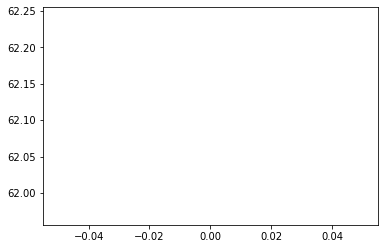

Generation :  2 / 100
Train Error: 57.66474630074965
Test Error: 57.32246569595129
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


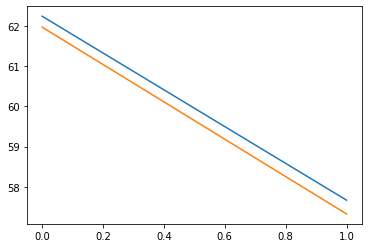

Generation :  3 / 100
Train Error: 55.640115090049534
Test Error: 55.26980878297669
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


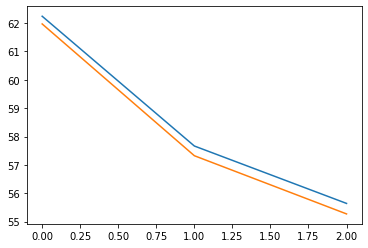

Generation :  4 / 100
Train Error: 54.242988495182914
Test Error: 53.879499736002884
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


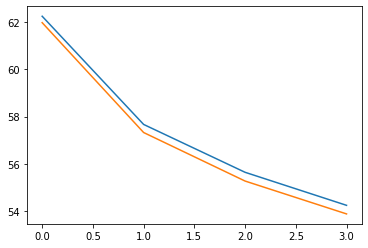

Generation :  5 / 100
Train Error: 52.7818702877516
Test Error: 52.42055688981379
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


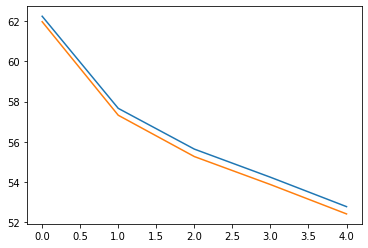

Generation :  6 / 100
Train Error: 53.51045712742125
Test Error: 53.11901241034395
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


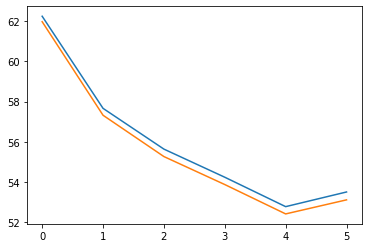

Generation :  7 / 100
Train Error: 51.659709743471495
Test Error: 51.27498640777866
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


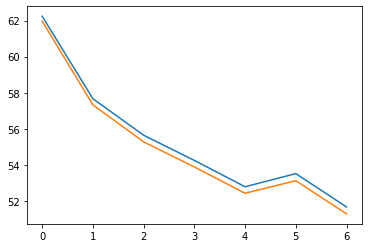

Generation :  8 / 100
Train Error: 48.74409724384542
Test Error: 48.41988857236588
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


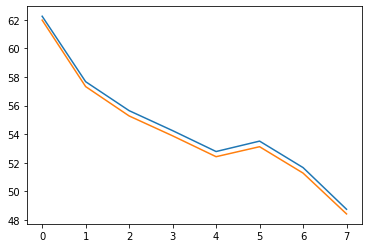

Generation :  9 / 100
Train Error: 47.47831089096377
Test Error: 47.09599572302929
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


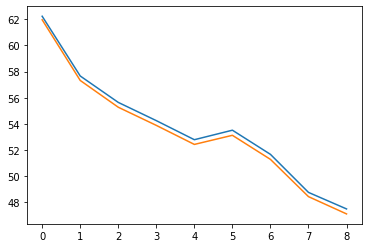

Generation :  10 / 100
Train Error: 48.839861047911526
Test Error: 48.473825715682516
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


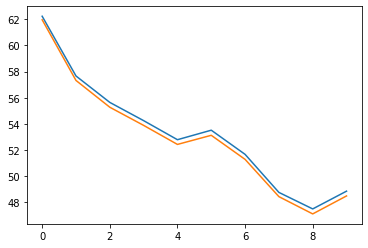

Generation :  11 / 100
Train Error: 47.86216798175279
Test Error: 47.55120526557474
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


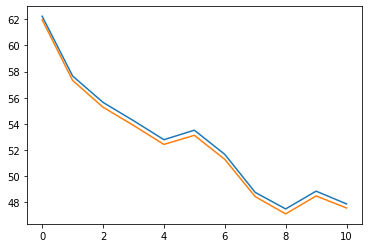

Generation :  12 / 100
Train Error: 45.21475767070252
Test Error: 44.91135543671446
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


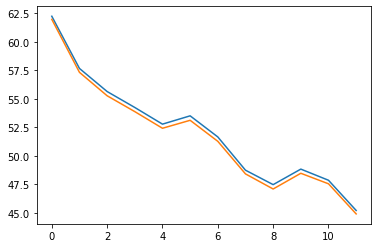

Generation :  13 / 100
Train Error: 47.03652535407647
Test Error: 46.68697067290885
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


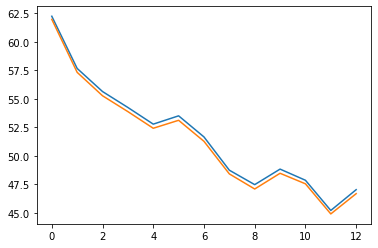

Generation :  14 / 100
Train Error: 46.08887459625563
Test Error: 45.794112585813934
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


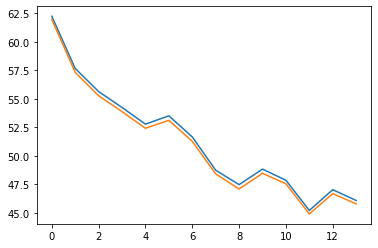

Generation :  15 / 100
Train Error: 45.37053946434145
Test Error: 45.068944608759715
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


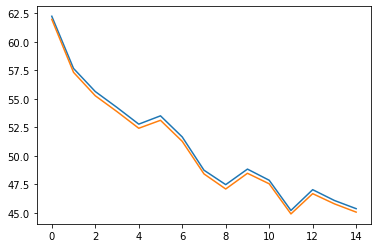

Generation :  16 / 100
Train Error: 46.60172361014998
Test Error: 46.36328751172573
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


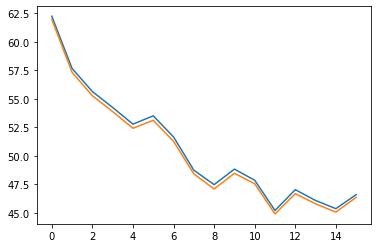

Generation :  17 / 100
Train Error: 46.400508506216774
Test Error: 46.15990802966336
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


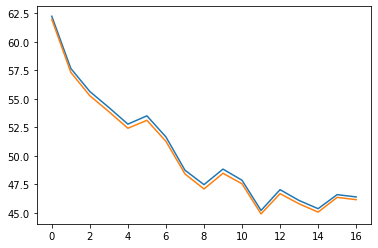

Generation :  18 / 100
Train Error: 43.523661887913185
Test Error: 43.171229811221195
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


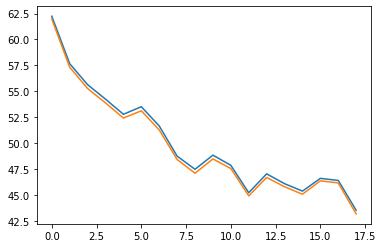

Generation :  19 / 100
Train Error: 45.99168563462618
Test Error: 45.704573320605775
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


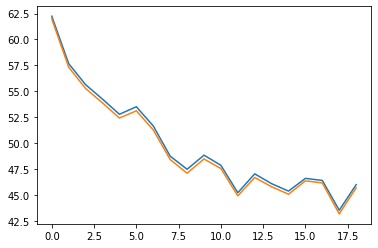

Generation :  20 / 100
Train Error: 46.93550528446918
Test Error: 46.64028614407506
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


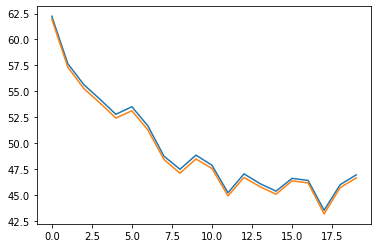

Generation :  21 / 100
Train Error: 45.753787481038806
Test Error: 45.45903292043353
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


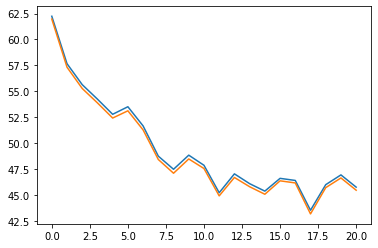

Generation :  22 / 100
Train Error: 44.94668863209604
Test Error: 44.66090620500364
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


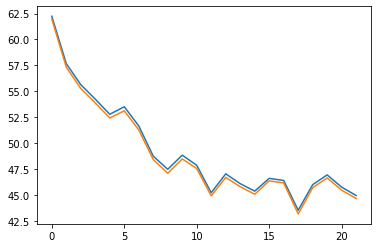

Generation :  23 / 100
Train Error: 44.84151274136148
Test Error: 44.57686506465433
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


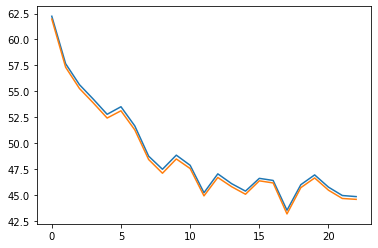

Generation :  24 / 100
Train Error: 44.84855415079061
Test Error: 44.54683666781453
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


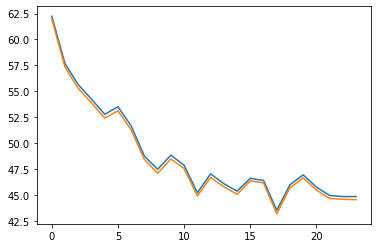

Generation :  25 / 100
Train Error: 45.55271968062533
Test Error: 45.245388377948345
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


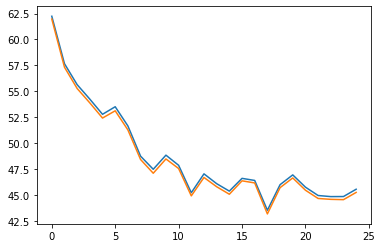

Generation :  26 / 100
Train Error: 46.04231033208638
Test Error: 45.66135599704813
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


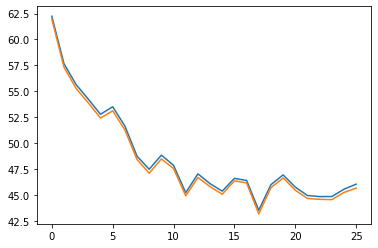

Generation :  27 / 100
Train Error: 46.604696228171264
Test Error: 46.19332542429623
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


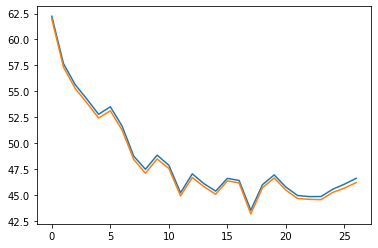

Generation :  28 / 100
Train Error: 46.50703360173988
Test Error: 46.18010459859039
20 New parents generated...
30 New offsprings produced...
30 offsprings mutated
New population created


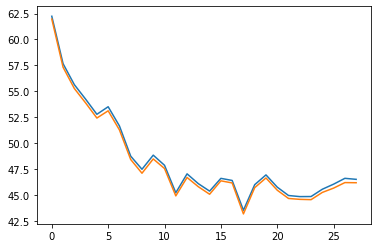

In [0]:
import multiprocessing as mp
output = mp.Queue()

#Genetic algorithm parameters:------------------------------------------------------------------------------------------------------------------------
#    Mating Pool Size (Number of Parents)
#    Population Size
#    Number of Generations
#    Mutation Percent

sol_per_pop = 50
num_parents_mating = 20 
num_generations = 28
mutation_percent = 20
ga = GA()

#initial population :       
population_vectors = np.random.uniform(-1., 1.,size=(sol_per_pop, 36)) #4*6 + 6*2 = 36 

train_error, test_error = [], []

for generation in range(num_generations):

    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(sol_per_pop).reshape(sol_per_pop,1)))
    
    processes=[]
    for syn in temp_population_vectors:
        p = mp.Process(target = mp_fitness, args=(syn, output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column

    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])

    train_error.append(np.mean(fitness_train))
    test_error.append(np.mean(fitness_test))
    
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    
    print('Train Error:', train_error[-1])
    print('Test Error:', test_error[-1])

    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    print(parents.shape[0],'New parents generated...')
    
    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    print('New population created')
    
    #Update the result of this generation in report files
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
    pickle.dump(train_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
    pickle.dump(test_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()

    plt.plot(train_error)
    plt.plot(test_error)
    plt.show()